In [1]:
from sklearn.datasets import load_boston
from sklearn.cross_validation import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

D:\conda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Задание 3
## Реализация собственного дерева
### Код

In [2]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, answer=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.answer = answer  # for leaf nodes only
        

class Splitted:  
    def __init__(self, feature=None, threshold=None, X_left=None, y_left=None, X_right=None, y_right=None):
        self.feature = feature
        self.threshold = threshold
        self.X_left = X_left
        self.y_left = y_left
        self.X_right = X_right
        self.y_right = y_right
        
        
class DecisionTree:
    def __init__(self, max_depth=None):
        self.root = None
        self.thresholds = None
        self.feature_num = None
        self.max_depth = max_depth if max_depth is not None else np.inf
        

    def generate_thresholds(self, X):
        thresholds = []
        for i in range(self.feature_num) :
            thresholds_i = np.unique(X[:,i])
            size = thresholds_i.size
            if (size > 50) :  # if we have too many unique values of the feature
                mask = np.round(np.linspace(1, size, 50, endpoint=False)).astype(int)
                thresholds_i = thresholds_i[mask]
        
            thresholds.append(thresholds_i)
        return thresholds    
    
        
    def build(self, X, y, my_depth):
        succeeded, split = self.split(X, y)
        
        if (my_depth >= self.max_depth or not succeeded):
            return Node(answer=np.mean(y))
        
        # recursively construct child nodes
        left = self.build(split.X_left, split.y_left, my_depth + 1)
        right = self.build(split.X_right, split.y_right, my_depth + 1)
        return Node(feature=split.feature, threshold=split.threshold, left=left, right=right)
    
    
    def MSE_criterion(self, y, y1, y2):
        H_L = np.var(y1)
        H_R = np.var(y2)
        return H_L * len(y1) / len(y) + H_R * len(y2) / len(y)
    
    
    def split(self, X, y):
        succeeded = False
        result = Splitted()
        min_err = np.inf
        
        for f in range(self.feature_num):
            for t in self.thresholds[f]:
                X1, y1, X2, y2 = self.split_data(X, y, f, t)
                if len(y1) > 0 and len(y2) > 0:
                    err = self.MSE_criterion(y, y1, y2)
                    if err < min_err:
                        succeeded = True
                        min_err = err
                        result = Splitted(f, t, X1, y1, X2, y2)
        return succeeded, result
    
    
    def split_data(self, X, y, feature_id, threshold):
        mask = X[:, feature_id] < threshold
        rev_mask = np.invert(mask)
        return np.compress(mask, X, axis=0), np.compress(mask, y), np.compress(rev_mask, X, axis=0), np.compress(rev_mask, y)
        
        
    def fit(self, X, y):
        self.feature_num = len(X[0])
        self.thresholds = self.generate_thresholds(X)
        self.root = self.build(X, y, 0)
    
    
    def predict(self, X):
        result = []
        for x in X:
            pos = self.root
            while (pos.answer is None) :
                pos = pos.left if x[pos.feature] < pos.threshold else pos.right
            result.append(pos.answer)
        return np.array(result)

### Проверка на датасете boston

In [3]:
boston = load_boston()
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
%%time

score = []
for depth in np.arange(1, 15):
    tree = DecisionTree(max_depth=depth)
    tree.fit(X_train, y_train)
    score.append(np.sum((y_test - tree.predict(X_test))**2) / len(y_test))

Wall time: 47.8 s


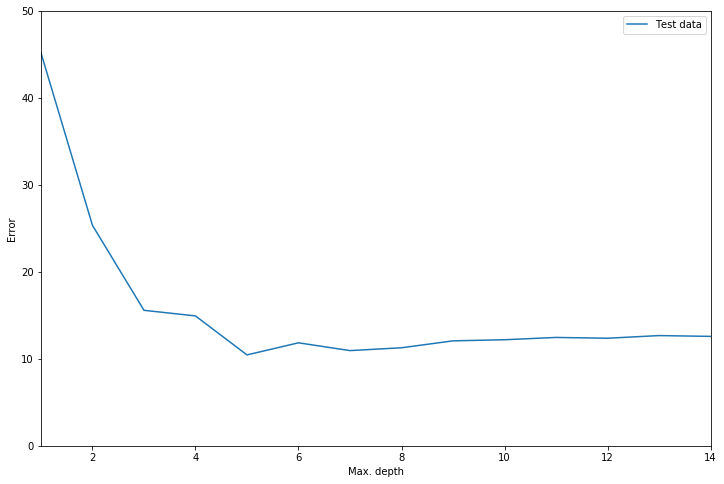

In [7]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, 15), score, label="Test data")
plt.xlabel("Max. depth")
plt.ylabel("Error")
plt.xlim(1, 14)
plt.ylim(0, 50)
plt.legend()
plt.show()